In [1]:
import sys
sys.path.append('..')

import torch

from inxss import PsiMask, NeutronExperiment

import matplotlib.pyplot as plt

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



In [2]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="../conf/final"):
    cfg = compose(config_name="config_poisson")

/tmp/ipykernel_2001090/1933380323.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../conf/final"):


In [3]:
data = torch.load(cfg['paths']['data_path'])

In [4]:
global_mask = (data['S']>0).bool()

grid_info = {
    k: [v.min().item(), v.max().item(), len(v)] for k,v in data['grid'].items()
}

In [5]:
mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": global_mask
}

In [6]:
psi_mask = PsiMask(**mask_config)

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [7]:
cmap = sns.color_palette("rocket", as_cmap=True)

/tmp/ipykernel_2001090/3157941881.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


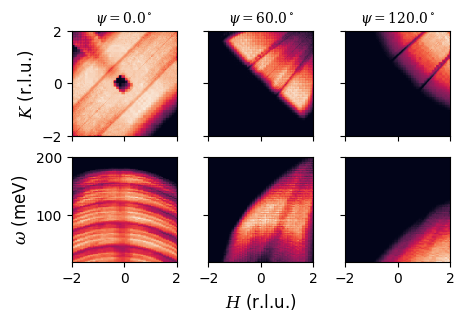

In [8]:
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(5, 3), sharex=True,
                         gridspec_kw={'hspace': 0.2})

angles = np.arange(3) * 360 / 6

for i in range(3):
    _mask = psi_mask.load_memmap_mask(angles[i])
    
    ax0 = axes[0, i]
    ax0.imshow(_mask.sum(-1).sum(-1).T, 
            origin='lower', extent=[-2, 2, 
                                    -2, 2],
            aspect=1, cmap=cmap)

    ax1 = axes[1, i]
    ax1.imshow(_mask.sum(1).sum(1).T, 
            origin='lower', extent=[-2, 2, 
                                    grid_info['w_grid'][0], grid_info['w_grid'][1]],
            aspect=4/(grid_info['w_grid'][1]- grid_info['w_grid'][0]), cmap=cmap)
    
    if i > 0:
        ax0.set_yticklabels([])
        ax1.set_yticklabels([])
    else:
        ax0.set_ylabel('$K$ (r.l.u.)')
        ax1.set_ylabel('$\omega$ (meV)')
    ax0.set_title(fr'$\psi = {angles[i]}^\circ$')
    if i == 1:
        ax1.set_xlabel('$H$ (r.l.u.)')

fig.tight_layout()
fig.savefig('figures/mask_demo.pdf', bbox_inches='tight', transparent=True)

In [17]:
experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": data['S'],
    "S_scale_factor": 1.
}
experiment = NeutronExperiment(**experiment_config)

In [24]:
experiment.prepare_experiment(psi_mask.hklw_grid)

In [102]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

_, kpt_indices = linspace_2D_equidistant([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]], 200, return_indices=True)
kpts = torch.from_numpy(linspace_2D_equidistant([[1/4,1/4],[1/2,1/2],[0,1/2],[1/4,1/4], [0,0], [0,1/2]], 200))
wpts = experiment.w_grid
qw_coords = []
for _l in experiment.l_grid:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)

S_exp = 0.
for _qw_coords in qw_coords:
    S_exp += experiment.get_measurements_on_coords(_qw_coords)

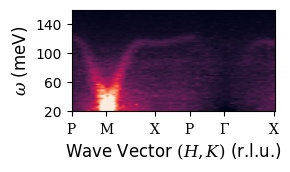

In [103]:
    
kpt_labels = ['$\mathrm{P}$', '$\mathrm{M}$', '$\mathrm{X}$', '$\mathrm{P}$', '$\Gamma$', '$\mathrm{X}$']

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.imshow(S_exp, origin='lower', cmap=cmap, 
          extent=[0,len(kpts),experiment.w_grid.min(),experiment.w_grid.max()],
          aspect=100 / 140, vmax=S_exp.max() * 0.5
)
ax.set_xlabel('Wave Vector $(H,K)$ (r.l.u.)')
ax.set_ylim([20, 160])
ax.set_yticks([20, 60, 100, 140])
ax.set_ylabel('$\omega$ (meV)')
ax.set_xticks(kpt_indices)
ax.set_xticklabels(kpt_labels)
fig.tight_layout()
fig.savefig('figures/S_exp.pdf', bbox_inches='tight', transparent=True)

In [129]:
# Construct a 100 x 91 x 3 tensor where (i, j, :) is the (k, w) coordinate defined in kpts and wpts
wpts_finer = torch.linspace(wpts.min(), wpts.max(), len(wpts) * 2)

kw_coords = torch.zeros((len(kpts), len(wpts_finer), 3))

for i in range(len(kpts)):
    for j in range(len(wpts_finer)):
        kw_coords[i, j, 0:2] = kpts[i]
        kw_coords[i, j, 2] = wpts_finer[j]

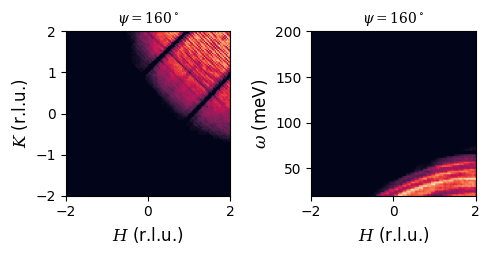

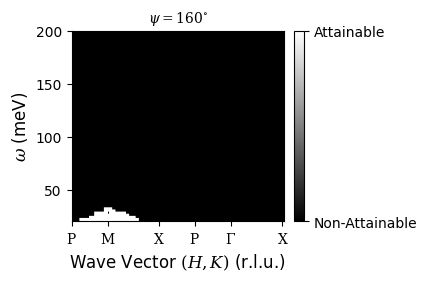

In [159]:
from scipy.interpolate import RegularGridInterpolator

fig, axes = plt.subplots(1, 2, figsize=(5, 3))

angles = [160]

for i in range(len(angles)):
    _mask = psi_mask.load_memmap_mask(angles[i])
    
    ax0 = axes[0]
    ax0.imshow(_mask.sum(-1).sum(-1).T, 
            origin='lower', extent=[-2, 2, 
                                    -2, 2],
            aspect=1, cmap=cmap)

    ax1 = axes[1]
    ax1.imshow(_mask.sum(1).sum(1).T, 
            origin='lower', extent=[-2, 2, 
                                    grid_info['w_grid'][0], grid_info['w_grid'][1]],
            aspect=4/(grid_info['w_grid'][1]- grid_info['w_grid'][0]), cmap=cmap)
    
    if i > 0:
        ax0.set_yticklabels([])
        ax1.set_yticklabels([])
    else:
        ax0.set_ylabel('$K$ (r.l.u.)')
        ax1.set_ylabel('$\omega$ (meV)')
    ax0.set_title(fr'$\psi = {angles[i]}^\circ$')
    ax1.set_title(fr'$\psi = {angles[i]}^\circ$')
    ax0.set_xlabel('$H$ (r.l.u.)')
    ax1.set_xlabel('$H$ (r.l.u.)')
        
fig.tight_layout()
fig.savefig(f'figures/mask_demo_at_{angles[0]}deg.pdf', bbox_inches='tight', transparent=True)

mask_interp_func = RegularGridInterpolator(
    [experiment.h_grid.numpy(), experiment.k_grid.numpy(), experiment.w_grid.numpy()],
    _mask.numpy().sum(-2),
    bounds_error=False, fill_value=0, method='linear'
)

mask_on_kpath = mask_interp_func(kw_coords)


from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
im = plt.imshow(mask_on_kpath.T>0, origin='lower', cmap='gray',
                extent=[0,len(kpts),experiment.w_grid.min(),experiment.w_grid.max()], )
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
cax.set_yticks([0, 1])
cax.set_yticklabels(['Non-Attainable', 'Attainable'])

ax.set_xticks(kpt_indices)
ax.set_xticklabels(kpt_labels)
ax.set_ylabel('$\omega$ (meV)')
ax.set_xlabel('Wave Vector $(H,K)$ (r.l.u.)')
ax.set_title(f'$\psi={angles[0]}^{{\circ}}$')

# fig.tight_layout()
fig.savefig(f'figures/mask_on_kpath_at_{angles[0]}deg.pdf', bbox_inches='tight', transparent=True)

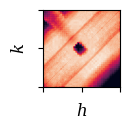

In [28]:
fig, ax = plt.subplots(1,1,figsize=(1,1))

_mask = psi_mask.load_memmap_mask(0)
ax.imshow(_mask.sum(-1).sum(-1).T, 
        origin='lower', extent=[-2, 2, -2, 2],
        aspect=1, cmap=cmap)
# ax.set_axis_off()
ax.set_xlabel('$h$')
ax.set_ylabel('$k$')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect('equal')
fig.savefig('figures/coverage_example.pdf', bbox_inches='tight', transparent=True)

In [29]:
kpts_vert = np.array([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]])
kpts_vert = np.array([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]])

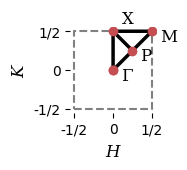

In [30]:
fig, ax = plt.subplots(1,1,figsize=(2,2))

ax.plot(*np.array([[-1/2,-1/2],[1/2,-1/2],[1/2,1/2],[-1/2,1/2],[-1/2,-1/2]]).T, color='0.5', linestyle='--', lw=1.5)
# ax.plot(*np.array([[0,0],[1,0],[1,1],[0,0]]).T, 'k-', lw=2.5, zorder=10)
ax.plot(*kpts_vert.T, 'k-', lw=2.5, zorder=10)
ax.plot(*np.array([[0,0],[1/4,1/4],[1/2,1/2],[0,1/2],[0,0]]).T, 'o', color='C2', zorder=20)
ax.text(0.1, 0.05, '$\Gamma$', ha='left', va='top', fontsize=12)
ax.text(0.1, 0.55, '$\mathrm{X}$', ha='left', va='bottom', fontsize=12)
ax.text(0.6, 0.55, '$\mathrm{M}$', ha='left', va='top', fontsize=12)
ax.text(0.35, 0.3, '$\mathrm{P}$', ha='left', va='top', fontsize=12)
# ax.set_axis_off()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_aspect('equal')
ax.set_xticks([-1/2, 0, 1/2])
ax.set_xticklabels(['-1/2', '0', '1/2'])
ax.set_yticks([-1/2, 0, 1/2])
ax.set_yticklabels(['-1/2', '0', '1/2'])

ax.set_xlabel('$H$')
ax.set_ylabel('$K$')

fig.tight_layout()
fig.savefig('figures/BZ.pdf', bbox_inches='tight', transparent=True)